In [1]:
import os

TENSORFLOW = 1
TORCH = 1
if TORCH:
    os.environ['CUDA_VISIBLE_DEVICES']='0'

if TENSORFLOW:
    import os
    import tensorflow as tf


    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            tf.config.set_visible_devices(gpus[0], 'GPU')
            tf.config.set_logical_device_configuration(
                gpus[0],
                [tf.config.LogicalDeviceConfiguration(memory_limit=10000)])
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            print(e)


2024-05-02 11:24:17.585757: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 11:24:17.585798: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 11:24:17.585830: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-02 11:24:17.592645: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


1 Physical GPUs, 1 Logical GPUs


2024-05-02 11:24:19.030247: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-02 11:24:19.034943: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-02 11:24:19.035147: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
import pandas as pd
from functools import reduce
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
import math
import tensorflow as tf


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

column_names = [
    'ID', 'PARAM', 'TYPE', 'YEAR', 'DD',
    'Jan', 'Jan_SYM', 'Feb', 'Feb_SYM', 'Mar', 'Mar_SYM',
    'Apr', 'Apr_SYM', 'May', 'May_SYM', 'Jun', 'Jun_SYM',
    'Jul', 'Jul_SYM', 'Aug', 'Aug_SYM', 'Sep', 'Sep_SYM',
    'Oct', 'Oct_SYM', 'Nov', 'Nov_SYM', 'Dec', 'Dec_SYM'
]

MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

data = pd.read_csv('data/credit_hydrometric_data_all_stations.csv', skiprows=2, names=column_names)

Num GPUs Available:  1


In [3]:
_02HB018 = data[data['ID'] == '02HB018'].reset_index(drop=True)

_02HB025 = data[data['ID'] == '02HB025'].reset_index(drop=True)

_02HB031 = data[data['ID'] == '02HB031'].reset_index(drop=True)

_02HB001 = data[data['ID'] == '02HB001'].reset_index(drop=True)

_02HB013 = data[data['ID'] == '02HB013'].reset_index(drop=True)

_02HB029 = data[data['ID'] == '02HB029'].reset_index(drop=True)  ### TARGET


In [4]:
import pandas as pd
import calendar

def is_valid_date(year, month, day):
    try:
        m = calendar.monthrange(year, month)
        if day > m[1]:
            return False
        else:
            return True
    except Exception as e:
        print(e)
        return False


def split_by_param_1_2(df: pd.DataFrame):
    data1 = df[df['PARAM'] == 1].reset_index(drop=True)
    data2 = df[df['PARAM'] == 2].reset_index(drop=True)
    return data1, data2

def wateroffice_to_timeseries(df : pd.DataFrame):
    data_dict = {'timestamp': [], 'value': []}

    for i, row in df.iterrows():
        year = row['YEAR']
        day = row['DD']
        for month in MONTHS :
            if is_valid_date(year, MONTHS.index(month) + 1, day):

                timestamp = pd.Timestamp(f'{year}-{month}-{day}')
                val = df.at[i, f'{month}']
                data_dict['timestamp'].append(timestamp)
                data_dict['value'].append(val)

    new_data = pd.DataFrame(data_dict)
    return new_data


def merge_param_1_2(df_left : pd.DataFrame, df_right : pd.DataFrame):
    return pd.merge(df_left, df_right, on='timestamp', how='inner')



In [5]:
_02HB018_1, _02HB018_2 = split_by_param_1_2(_02HB018)
_02HB025_1, _02HB025_2 = split_by_param_1_2(_02HB025)
_02HB031_1, _02HB031_2 = split_by_param_1_2(_02HB031)
_02HB001_1, _02HB001_2 = split_by_param_1_2(_02HB001)
_02HB013_1, _02HB013_2 = split_by_param_1_2(_02HB013)
_02HB029_1, _02HB029_2 = split_by_param_1_2(_02HB029)



In [6]:
_02HB018_1_ts = wateroffice_to_timeseries(_02HB018_1).rename(columns={'value': 'discharge_02HB018'})
_02HB018_2_ts = wateroffice_to_timeseries(_02HB018_2).rename(columns={'value': 'water_level_02HB018'})
_02HB025_1_ts = wateroffice_to_timeseries(_02HB025_1).rename(columns={'value': 'discharge_02HB025'})
_02HB025_2_ts = wateroffice_to_timeseries(_02HB025_2).rename(columns={'value': 'water_level_02HB025'})
_02HB031_1_ts = wateroffice_to_timeseries(_02HB031_1).rename(columns={'value': 'discharge_02HB031'})
_02HB031_2_ts = wateroffice_to_timeseries(_02HB031_2).rename(columns={'value': 'water_level_02HB031'})
_02HB001_1_ts = wateroffice_to_timeseries(_02HB001_1).rename(columns={'value': 'discharge_02HB001'})
_02HB001_2_ts = wateroffice_to_timeseries(_02HB001_2).rename(columns={'value': 'water_level_02HB001'})
_02HB013_1_ts = wateroffice_to_timeseries(_02HB013_1).rename(columns={'value': 'discharge_02HB013'})
_02HB013_2_ts = wateroffice_to_timeseries(_02HB013_2).rename(columns={'value': 'water_level_02HB013'})
_02HB029_1_ts = wateroffice_to_timeseries(_02HB029_1).rename(columns={'value': 'discharge_02HB029'})
_02HB029_2_ts = wateroffice_to_timeseries(_02HB029_2).rename(columns={'value': 'water_level_02HB029'})

In [7]:
def merge_param_1_2(df_left : pd.DataFrame, df_right : pd.DataFrame):
    return pd.merge(df_left, df_right, on='timestamp', how='inner')

In [8]:
merged_02HB018 = merge_param_1_2(_02HB018_1_ts, _02HB018_2_ts)
merged_02HB025 = merge_param_1_2(_02HB025_1_ts, _02HB025_2_ts)
merged_02HB031 = merge_param_1_2(_02HB031_1_ts, _02HB031_2_ts)
merged_02HB001 = merge_param_1_2(_02HB001_1_ts, _02HB001_2_ts)
merged_02HB013 = merge_param_1_2(_02HB013_1_ts, _02HB013_2_ts)
merged_02HB029 = merge_param_1_2(_02HB029_1_ts, _02HB029_2_ts)


In [9]:
# merge into single dataframe with dischrage and water_level for all stations and add suffix to columns, dont have redundant columns
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['timestamp'],
                                            how='outer'), [merged_02HB018, merged_02HB025, merged_02HB031, merged_02HB001, merged_02HB013, merged_02HB029])

In [10]:
print(df_merged['timestamp'].diff().dt.days.unique())

[nan  1.]


In [11]:
df_merged.set_index('timestamp', inplace=True)

In [12]:
df_merged.ffill(inplace=True)
df_merged.bfill(inplace=True)

In [13]:
df_merged.head(2)

,discharge_02HB018,water_level_02HB018,discharge_02HB025,water_level_02HB025,discharge_02HB031,water_level_02HB031,discharge_02HB001,water_level_02HB001,discharge_02HB013,water_level_02HB013,discharge_02HB029,water_level_02HB029
timestamp,,,,,,,,,,,,
2002-01-01,2.50,3.944,3.27,2.829,0.288,2.014,1.20,1.475,0.380,11.205,12.1,4.563
2002-01-02,2.47,3.983,3.24,2.857,0.288,2.014,1.19,1.473,0.375,11.204,12.1,4.563


In [44]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU, BatchNormalization, Bidirectional, LayerNormalization, ConvLSTM1D, Flatten, Dropout

def make_lstm(input_shape):

    #_LSTM = Sequential()
    #_LSTM.add(LSTM(100, return_sequences=True, input_shape=input_shape, dropout=0.2, recurrent_dropout=0.2))
    #_LSTM.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    #_LSTM.add(Dense(1))
    _LSTM = Sequential()
    _LSTM.add(Bidirectional(LSTM(100, return_sequences=True, input_shape=input_shape, dropout=0.2, recurrent_dropout=0.2)))
    _LSTM.add(BatchNormalization())
    _LSTM.add(Bidirectional(LSTM(50, dropout=0.2, recurrent_dropout=0.2)))
    _LSTM.add(BatchNormalization())
    _LSTM.add(Dense(1))

    return _LSTM

def make_gru(input_shape):

    _GRU = Sequential()
    _GRU.add(GRU(50, return_sequences=True, input_shape=input_shape, dropout=0.2))
    _GRU.add(LayerNormalization())
    _GRU.add(GRU(25, dropout=0.2))
    _GRU.add(Dense(1))

    return _GRU

def make_conv_lstm(input_shape):
    _CONVLSTM = Sequential()
    _CONVLSTM.add(ConvLSTM1D(filters=32, kernel_size=3, return_sequences=True, input_shape=input_shape))
    _CONVLSTM.add(BatchNormalization())
    #_CNNLSTM.add(ConvLSTM1D(filters=32, kernel_size=3, return_sequences=False))
    #_CNNLSTM.add(BatchNormalization())
    _CONVLSTM.add(Flatten())
    _CONVLSTM.add(Dense(50, activation='relu'))
    _CONVLSTM.add(Dropout(0.25))
    _CONVLSTM.add(Dense(1))

    return _CONVLSTM

In [46]:



from keras.optimizers import Adam


scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df_merged)

def create_dataset(data :np.array, look_back=1):
    """
    set y as the next value in the sequence at the last index (water_level_02HB029)
    """
    X, Y = [], []
    for i in range(len(data) - look_back):
        a = data[i:(i + look_back), :]
        X.append(a)
        Y.append(data[i + look_back, -1])
    return np.array(X), np.array(Y)

look_back = 1
X, Y = create_dataset(df_scaled, look_back)

test_size = int(len(X) * 0.20)
train_size = len(X) - test_size
val_size = int(train_size * 0.20)

X_train, X_val = X[:train_size-val_size], X[train_size-val_size:train_size]
Y_train, Y_val = Y[:train_size-val_size], Y[train_size-val_size:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]

#model = make_gru((look_back, df_scaled.shape[1]))
#model = make_lstm((look_back, df_scaled.shape[1]))
model = make_conv_lstm((look_back, df_scaled.shape[1],1))

adam = Adam(lr=0.001)
model.compile(loss='mean_squared_error', optimizer=adam)

history = model.fit(X_train, Y_train, epochs=100, batch_size=256, verbose=2,
                     validation_data=(X_val, Y_val))

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(
    np.hstack((np.zeros((predictions.shape[0], df_scaled.shape[1]-1)), predictions)))

Y_test = scaler.inverse_transform(
    np.hstack((np.zeros((Y_test.shape[0], df_scaled.shape[1]-1)), Y_test.reshape(-1, 1))))[:, -1]

predictions = predictions[:, -1]

rmse = math.sqrt(mean_squared_error(Y_test, predictions))
mae = np.mean(np.abs(predictions - Y_test))
print(f'Test Score: {mae:.2f} MAE')
print(f'Test Score: {rmse:.2f} RMSE')

Epoch 1/100
21/21 - 3s - loss: 0.0811 - val_loss: 0.0161 - 3s/epoch - 130ms/step
Epoch 2/100
21/21 - 0s - loss: 0.0195 - val_loss: 0.0083 - 93ms/epoch - 4ms/step
Epoch 3/100
21/21 - 0s - loss: 0.0140 - val_loss: 0.0073 - 82ms/epoch - 4ms/step
Epoch 4/100
21/21 - 0s - loss: 0.0120 - val_loss: 0.0068 - 75ms/epoch - 4ms/step
Epoch 5/100
21/21 - 0s - loss: 0.0107 - val_loss: 0.0066 - 78ms/epoch - 4ms/step
Epoch 6/100
21/21 - 0s - loss: 0.0100 - val_loss: 0.0063 - 80ms/epoch - 4ms/step
Epoch 7/100
21/21 - 0s - loss: 0.0088 - val_loss: 0.0056 - 78ms/epoch - 4ms/step
Epoch 8/100
21/21 - 0s - loss: 0.0082 - val_loss: 0.0054 - 88ms/epoch - 4ms/step
Epoch 9/100
21/21 - 0s - loss: 0.0078 - val_loss: 0.0053 - 81ms/epoch - 4ms/step
Epoch 10/100
21/21 - 0s - loss: 0.0076 - val_loss: 0.0052 - 80ms/epoch - 4ms/step
Epoch 11/100
21/21 - 0s - loss: 0.0071 - val_loss: 0.0049 - 83ms/epoch - 4ms/step
Epoch 12/100
21/21 - 0s - loss: 0.0071 - val_loss: 0.0049 - 79ms/epoch - 4ms/step
Epoch 13/100
21/21 - 0s -

In [34]:
del model

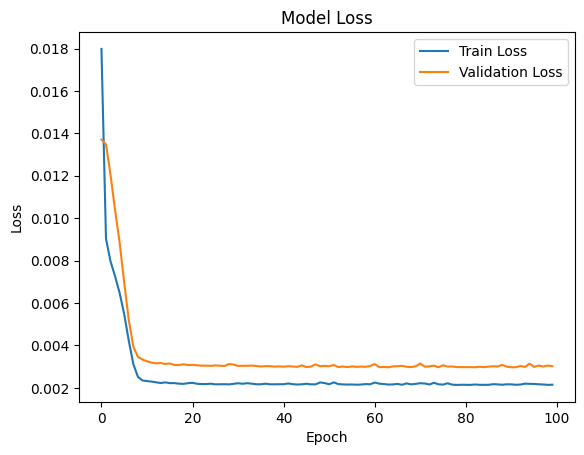

In [35]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()